<a href="https://colab.research.google.com/github/jharishr/html-portfolio/blob/main/Another_copy_of_ct_model1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageOps

from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr

import os

In [ ]:
def resize_with_padding(image, target_size=(256, 256)):
  image.thumbnail(target_size, Image.LANCZOS)
  delta_w = target_size[0] - image.width
  delta_h = target_size[1] - image.height
  padding = (delta_w // 2, delta_h // 2, delta_w - delta_w // 2, delta_h - delta_h // 2)
  return ImageOps.expand(image, padding, fill=0)

In [ ]:
from torch.utils.data import Dataset
import os
from PIL import Image
from torchvision import transforms

class CTSinogramDataset(Dataset):
    def __init__(self, sinogram_dir, ct_dir):
        self.sinogram_dir = sinogram_dir
        self.ct_dir = ct_dir

        valid_exts = (".jpg", ".jpeg", ".png", ".bmp", ".tif")

        # Load and sort CT file names
        self.ct_files = sorted([
            os.path.join(ct_dir, f)
            for f in os.listdir(ct_dir)
            if f.lower().endswith(valid_exts)
        ])

        # Extract just the base names of CTs (e.g., "001.jpg")
        ct_base_names = [os.path.basename(f) for f in self.ct_files]

        # Now only pick sinogram files that match the CTs
        self.sinogram_files = [
            os.path.join(sinogram_dir, f)
            for f in ct_base_names  # match CT filenames exactly
            if os.path.exists(os.path.join(sinogram_dir, f))
        ]

        # Re-check length after filtering
        assert len(self.sinogram_files) == len(self.ct_files), \
            f"Mismatch after filtering: {len(self.sinogram_files)} sinograms, {len(self.ct_files)} CTs"

    def __len__(self):
        return len(self.sinogram_files)

    def __getitem__(self, idx):
        sinogram = Image.open(self.sinogram_files[idx]).convert('L').resize((256, 256))
        ct_image = Image.open(self.ct_files[idx]).convert('L').resize((256, 256))

        sinogram_tensor = transforms.ToTensor()(sinogram)
        ct_tensor = transforms.ToTensor()(ct_image)

        return sinogram_tensor, ct_tensor


In [ ]:
from google.colab import files

print("Upload your Sinograms")
uploaded_sinogram = files.upload()

print("Now upload your CT Images")
uploaded_ct = files.upload()

Upload your Sinograms


Saving FILTERED_BRAIN_CT_SINOGRAMS.zip.zip to FILTERED_BRAIN_CT_SINOGRAMS.zip (3).zip
Now upload your CT Images


Saving Brain_CT.zip.zip to Brain_CT.zip (3).zip


In [ ]:
import zipfile

# Sinogram ZIP extraction
with zipfile.ZipFile("FILTERED_BRAIN_CT_SINOGRAMS.zip.zip", 'r') as zip_ref:
    zip_ref.extractall("FILTERED_BRAIN_CT_SINOGRAMS")

# CT ZIP extraction
with zipfile.ZipFile("Brain_CT.zip.zip", 'r') as zip_ref:
    zip_ref.extractall("Brain_CT")

print("✅ Both folders extracted successfully!")


✅ Both folders extracted successfully!


In [ ]:
# Updated paths pointing directly to the inner folders
sinogram_path = "/content/FILTERED_BRAIN_CT_SINOGRAMS/FILTERED_BRAIN_CT_SINOGRAMS"
ct_path = "/content/Brain_CT/Brain_CT"

# Recreate dataset and dataloader
dataset = CTSinogramDataset(sinogram_path, ct_path)

from torch.utils.data import random_split, DataLoader

# Split the dataset: 80% for training, 20% for testing
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Create separate DataLoaders
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)


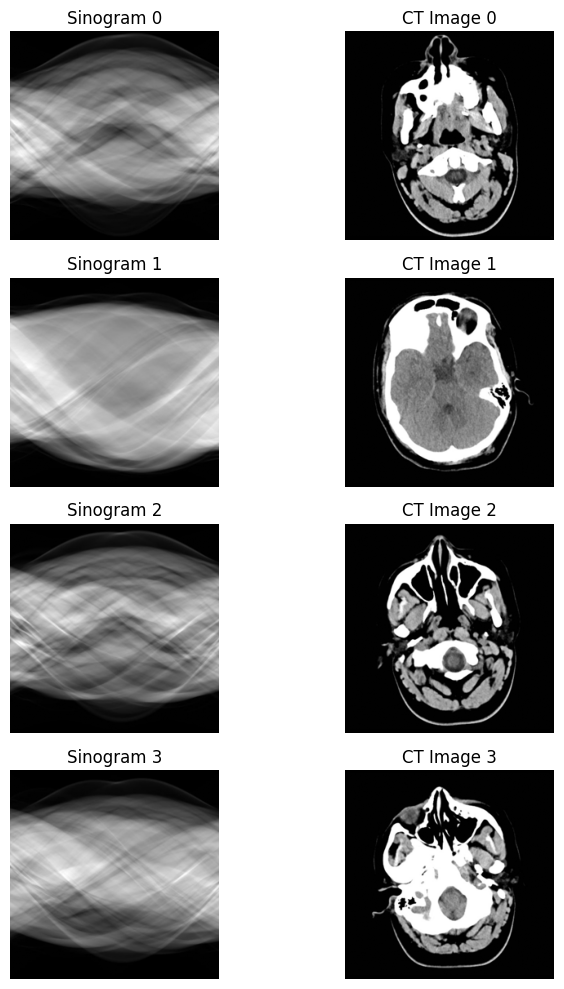

In [ ]:
import matplotlib.pyplot as plt

# Load a fresh batch of 4
dataloader = torch.utils.data.DataLoader(dataset, batch_size=4, shuffle=False)
sinograms, ct_images = next(iter(dataloader))

# Plot side-by-side
fig, axs = plt.subplots(4, 2, figsize=(8, 10))

for i in range(4):
    axs[i, 0].imshow(sinograms[i][0], cmap='gray')
    axs[i, 0].set_title(f"Sinogram {i}")
    axs[i, 0].axis('off')

    axs[i, 1].imshow(ct_images[i][0], cmap='gray')
    axs[i, 1].set_title(f"CT Image {i}")
    axs[i, 1].axis('off')

plt.tight_layout()
plt.show()


In [ ]:
print("Number of sinogram images loaded:", len(os.listdir(sinogram_path)))
print("Number of CT images loaded:", len(os.listdir(ct_path)))

# Check how many valid image pairs the Dataset class sees
print("Length of dataset object:", len(dataset))


Number of sinogram images loaded: 250
Number of CT images loaded: 125
Length of dataset object: 125


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
class ConvBlock(nn.Module):
  def _init_(self, in_channels, out_channels):
    super(ConvBlock, self)._init_()
    self.block = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size = 3, padding = 1),
        nn.ReLU(inplace = True),
        nn.Conv2d(out_channels, out_channels, kernel_size = 3, padding = 1),
        nn.ReLU(inplace = True)
    )

    def forward(self, x):
      return self.block(x)

In [ ]:
import torch
import torch.nn as nn

# ✅ ConvBlock MUST be defined BEFORE UNet
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ConvBlock, self).__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.block(x)

# ✅ Now the full UNet
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()

        # Encoder
        self.enc1 = ConvBlock(1, 64)
        self.pool1 = nn.MaxPool2d(2)

        self.enc2 = ConvBlock(64, 128)
        self.pool2 = nn.MaxPool2d(2)

        self.enc3 = ConvBlock(128, 256)
        self.pool3 = nn.MaxPool2d(2)

        self.enc4 = ConvBlock(256, 512)
        self.pool4 = nn.MaxPool2d(2)

        # Bottleneck
        self.bottleneck = ConvBlock(512, 1024)

        # Decoder
        self.upconv4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.dec4 = ConvBlock(1024, 512)

        self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec3 = ConvBlock(512, 256)

        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec2 = ConvBlock(256, 128)

        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec1 = ConvBlock(128, 64)

        # Final layer
        self.final_conv = nn.Conv2d(64, 1, kernel_size=1)

    def forward(self, x):
        e1 = self.enc1(x)
        p1 = self.pool1(e1)

        e2 = self.enc2(p1)
        p2 = self.pool2(e2)

        e3 = self.enc3(p2)
        p3 = self.pool3(e3)

        e4 = self.enc4(p3)
        p4 = self.pool4(e4)

        b = self.bottleneck(p4)

        d4 = self.upconv4(b)
        d4 = torch.cat((e4, d4), dim=1)
        d4 = self.dec4(d4)

        d3 = self.upconv3(d4)
        d3 = torch.cat((e3, d3), dim=1)
        d3 = self.dec3(d3)

        d2 = self.upconv2(d3)
        d2 = torch.cat((e2, d2), dim=1)
        d2 = self.dec2(d2)

        d1 = self.upconv1(d2)
        d1 = torch.cat((e1, d1), dim=1)
        d1 = self.dec1(d1)

        out = self.final_conv(d1)
        return out


In [ ]:
model = UNet()
x = torch.randn(1, 1, 256, 256)  # batch of 1 grayscale image
y = model(x)
print("Output shape:", y.shape)  # Should be [1, 1, 256, 256]


Output shape: torch.Size([1, 1, 256, 256])


In [ ]:
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

model = UNet().to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-4)

Using device: cuda


In [ ]:
from skimage.metrics import structural_similarity as ssim
import torch.nn.functional as F

def custom_loss(pred, target):
    mse_loss = F.mse_loss(pred, target)

    # SSIM component (batch-wise)
    ssim_score = 0
    pred_np = pred.detach().cpu().numpy()
    target_np = target.detach().cpu().numpy()

    for i in range(pred_np.shape[0]):
        ssim_score += ssim(target_np[i][0], pred_np[i][0], data_range=1.0)

    ssim_score /= pred_np.shape[0]

    # Combined loss: MSE + (1 - SSIM)
    alpha = 0.84  # weight for MSE
    beta = 0.16   # weight for SSIM
    total_loss = alpha * mse_loss + beta * (1 - ssim_score)

    return total_loss


In [ ]:
num_epochs = 30
best_loss = float('inf')  # initialize best loss as infinity

model.train()

for epoch in range(num_epochs):
    running_loss = 0.0

    for batch_idx, (sinograms, ct_images) in enumerate(train_loader):
        sinograms = sinograms.to(device)
        ct_images = ct_images.to(device)

        outputs = model(sinograms)
        loss = custom_loss(outputs, ct_images)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        if (batch_idx + 1) % 10 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx+1}], Loss: {loss.item():.6f}")

    avg_loss = running_loss / len(train_loader)
    print(f"✅ Epoch [{epoch+1}/{num_epochs}] completed — Average Loss: {avg_loss:.6f}")

    # Save model if this epoch has the best loss so far
    if avg_loss < best_loss:
        best_loss = avg_loss
        torch.save(model.state_dict(), "best_model_unet.pth")
        print(f"📦 Saved best model at epoch {epoch+1} with loss {avg_loss:.6f}")


Epoch [1/30], Batch [10], Loss: 0.132478
Epoch [1/30], Batch [20], Loss: 0.147239
✅ Epoch [1/30] completed — Average Loss: 0.140946
📦 Saved best model at epoch 1 with loss 0.140946
Epoch [2/30], Batch [10], Loss: 0.124974
Epoch [2/30], Batch [20], Loss: 0.151242
✅ Epoch [2/30] completed — Average Loss: 0.142247
Epoch [3/30], Batch [10], Loss: 0.138735
Epoch [3/30], Batch [20], Loss: 0.142729
✅ Epoch [3/30] completed — Average Loss: 0.137069
📦 Saved best model at epoch 3 with loss 0.137069
Epoch [4/30], Batch [10], Loss: 0.134618
Epoch [4/30], Batch [20], Loss: 0.126968
✅ Epoch [4/30] completed — Average Loss: 0.136370
📦 Saved best model at epoch 4 with loss 0.136370
Epoch [5/30], Batch [10], Loss: 0.122948
Epoch [5/30], Batch [20], Loss: 0.132901
✅ Epoch [5/30] completed — Average Loss: 0.137277
Epoch [6/30], Batch [10], Loss: 0.136927
Epoch [6/30], Batch [20], Loss: 0.135526
✅ Epoch [6/30] completed — Average Loss: 0.135550
📦 Saved best model at epoch 6 with loss 0.135550
Epoch [7/30]

In [ ]:
# Recreate model and load best saved weights
model = UNet().to(device)
model.load_state_dict(torch.load("best_model_unet.pth"))
model.eval()
print("✅ Best model loaded and ready for evaluation")


✅ Best model loaded and ready for evaluation



📊 Evaluation on Test Batch
Average PSNR : 13.36
Average SSIM : 0.4984


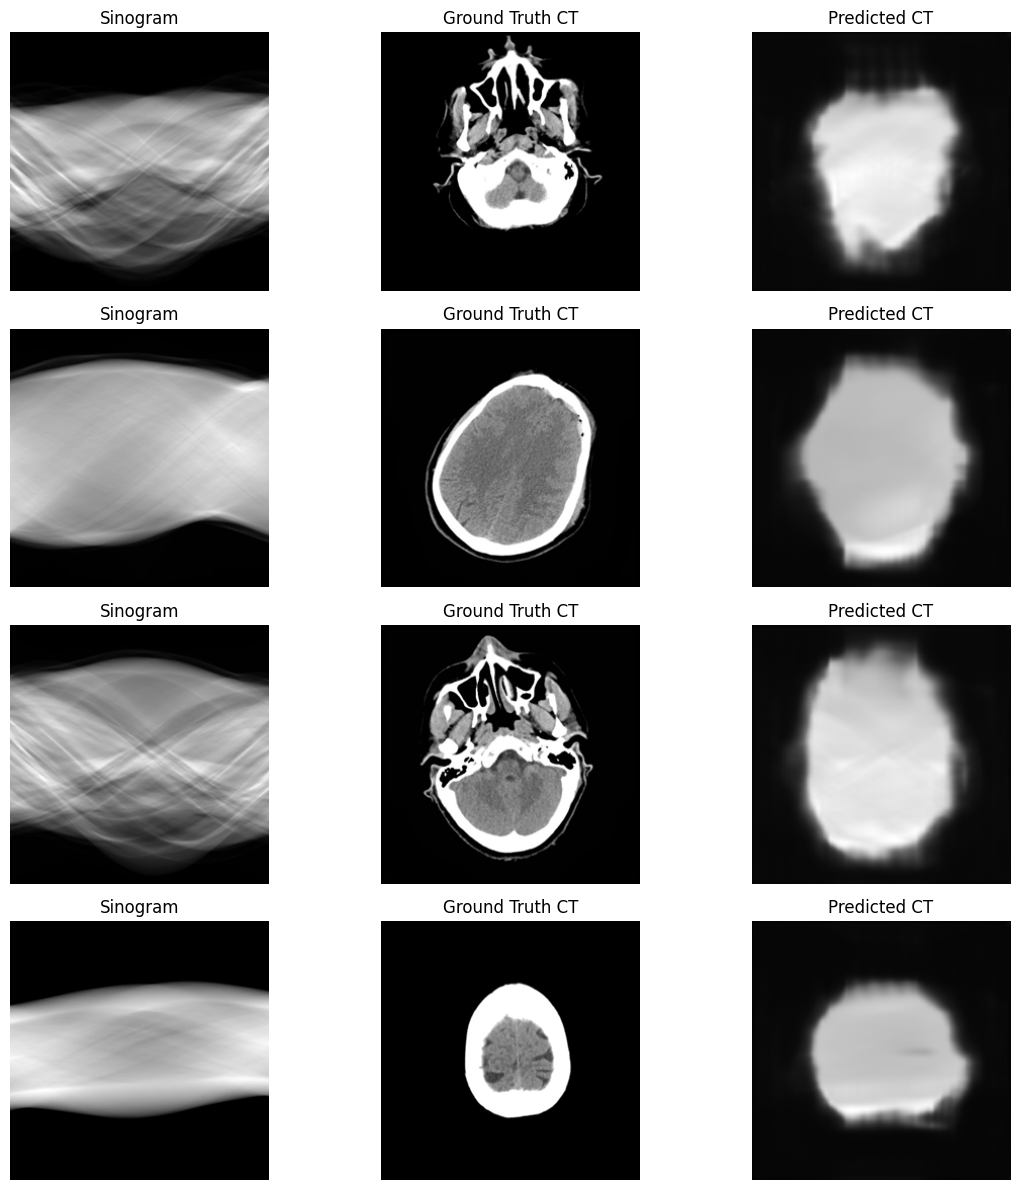

In [ ]:
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
import numpy as np

# Get a batch of test images
sinograms, ct_images = next(iter(test_loader))
sinograms = sinograms.to(device)
ct_images = ct_images.to(device)

# Predict with no gradient tracking
with torch.no_grad():
    predictions = model(sinograms)

# Convert to NumPy for visualization & metrics
sinograms = sinograms.cpu().numpy()
ct_images = ct_images.cpu().numpy()
predictions = predictions.cpu().numpy()

# --- PSNR and SSIM evaluation ---
total_psnr = 0
total_ssim = 0
num_images = predictions.shape[0]

for i in range(num_images):
    gt = ct_images[i][0]
    pred = predictions[i][0]

    total_psnr += psnr(gt, pred, data_range=1.0)
    total_ssim += ssim(gt, pred, data_range=1.0)

avg_psnr = total_psnr / num_images
avg_ssim = total_ssim / num_images

print(f"\n📊 Evaluation on Test Batch")
print(f"Average PSNR : {avg_psnr:.2f}")
print(f"Average SSIM : {avg_ssim:.4f}")

# --- Plot sinogram, ground truth, and predicted CT ---
fig, axs = plt.subplots(num_images, 3, figsize=(12, 3 * num_images))

for i in range(num_images):
    axs[i, 0].imshow(sinograms[i][0], cmap='gray')
    axs[i, 0].set_title("Sinogram")
    axs[i, 0].axis('off')

    axs[i, 1].imshow(ct_images[i][0], cmap='gray')
    axs[i, 1].set_title("Ground Truth CT")
    axs[i, 1].axis('off')

    axs[i, 2].imshow(predictions[i][0], cmap='gray')
    axs[i, 2].set_title("Predicted CT")
    axs[i, 2].axis('off')

plt.tight_layout()
plt.show()


In [ ]:
from torchvision.utils import save_image

# Save first 4 predictions to disk
for i in range(min(4, predictions.shape[0])):
    save_image(torch.tensor(predictions[i]), f"predicted_ct_{i+1}.png")
    save_image(torch.tensor(ct_images[i]), f"ground_truth_ct_{i+1}.png")
